# Navier Stokes with energy input from the bottom edge

This code runs a Navier Stokes simulator with particle movement included. The evolution of the fluid will be created by a force in the y direction
along the top edge (y=1). The magnitude of the force will be Gaussian with a peak at x=0.5, and grow over time. Guassian noise will be added to this force. 


                             _________________________
                         y=1|                         |           |
                            |                         |           |     Force downwards at each point due to gravity
                            |    O                    |           v
                            |               O         |
                            |                         |
                            |        O                |
                            |                         |
                            |               O         |
                         y=0|_________________________|
                         x=0                           x=1
                             ^  ^  ^  ^  ^  ^  ^  ^  ^  
                             :  |  |  |  |  |  |  |  :      Velocity on bottom edge due to heating
                                   :  |  |  |  :
                                         :    
Boundary Conditions:
* The boundary conditions for velocity are Dirichlet, meaning that the value of the velocities on the boundary are known and enforced. For the left, 
   right and top edges, the velocities are set to 0, in line with the "no slip" condition of viscous fluids. Along the bottom edge, the velocity of the fluid is set to the to value generated by the force explained above, with some noise added.
* The boundary condition for the pressure is Neumann, meaning that the gradient of the pressure across the boundary is known and enforced. This is set as 0.

Initial Conditions:
* The initial conditions for velocity are a generated Divergence Free field, generated using the code provided by Niall Jeffrey's in the python notebook "divergence_free_field.py". 
* The pressure at each point is generated from the standard normal distribution.
* The x and y coordinates of the particles are generated from a uniform distribution between 0 and 1. 

In [ ]:
from navier_stokes_2D import kinetic_energy, progress_timestep_with_particles
from initial_conditions import initial_conditions, heating_fluctuations
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import math
import time as time
import jax.config as config
import numpy as np

import imageio

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

In [ ]:
"""Determine Constants."""

TIMESTEPS = 200000
NUM_POINTS = 128   # How many points to split x and y axis into.
dt = 0.00001        # The size of the timesteps.
IMAGE_SCALAR = math.ceil(NUM_POINTS / 32)       # This is used to ensure the output images aren't too dense, so they can actually be made out. 
X, Y = jnp.meshgrid(jnp.linspace(0, 1, NUM_POINTS), jnp.linspace(0, 1, NUM_POINTS)) # This is only relevant for plotting, not for the physics.

# This function creates all the required initial conditions. 
state = initial_conditions(num_points=NUM_POINTS)

#This produces the plot of the initial conditions.
plt.figure()
plt.contourf(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], state.T[::IMAGE_SCALAR, ::IMAGE_SCALAR], 100, cmap="coolwarm")
plt.colorbar()
plt.quiver(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], state.u[::IMAGE_SCALAR, ::IMAGE_SCALAR], state.v[::IMAGE_SCALAR, ::IMAGE_SCALAR], color="black")
plt.show()

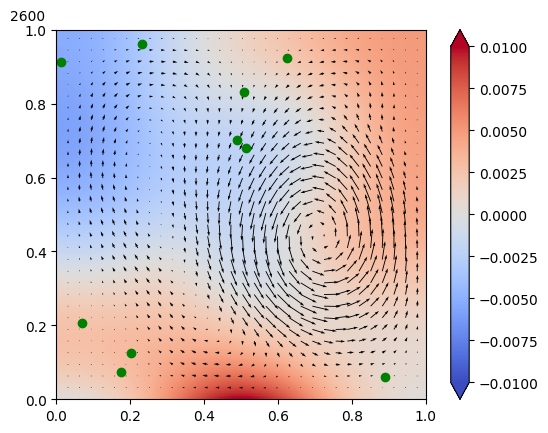

In [3]:
"""Run training loop and save images."""
    
for i in range(TIMESTEPS):
    # update the velocities and pressure.
    state = progress_timestep_with_particles(state)
    
    # If it is currently less that 100000 timesteps, increase the y velocity along the top edge. Once 100000 timesteps have been reached, 
    # the velocity should stay around the same value but vary due to the noise. 
    #if i >= 1000:
        # Increase the velocity. The second added term is to add noise to the field.
         
    state = heating_fluctuations(state, min(0.1, i/10000), min(0.05, 0.05/1000))
    
    
    # Print the time and kinetic energy every 1000 timesteps, and save an image of the current state.
    if i % 100 == 0:
        print(f"timestep: {i}, time: {i* dt}")
        print(f"Kinetic Energy = {kinetic_energy(state)}")
        plt.figure()
        plt.imshow(state.T, extent=(0, 1, 0, 1), cmap="coolwarm")
        plt.clim(vmin=-0.01, vmax=0.01)
        plt.colorbar(extend='both')
        plt.figtext(0.15, 0.9, str(i), ha="right")
        
        Q = plt.quiver(X[::IMAGE_SCALAR, ::IMAGE_SCALAR], Y[::IMAGE_SCALAR, ::IMAGE_SCALAR], state.u[::IMAGE_SCALAR, ::IMAGE_SCALAR], state.v[::IMAGE_SCALAR, ::IMAGE_SCALAR])
        plt.scatter(state.x, state.y, color="g")
        plt.margins(x=0, y=0)
        

        plt.savefig(f'img_{int(i/100)}.png',
                  transparent = False,  
                  facecolor = 'white'
               )
        plt.close()

In [ ]:
"""Make images into a gif."""
frames = []
for i in range(100):
  image = imageio.v2.imread(f'img_{int(i)}.png')
  frames.append(image)

imageio.mimsave('./example.gif', # output gif
                frames,          # array of input frames
                duration=0.01)         # optional: frames per second """